In [1]:
import tensorflow as tf
from keras.layers import Input, Conv2D, Activation, BatchNormalization, UpSampling2D
from keras.layers import Add
from keras.layers import Dropout
from layer_utils import ReflectionPadding2D
from keras.layers import Lambda
from keras.models import Model

In [2]:

def res_block(input, filters, kernel_size=(3,3), strides=(1,1), use_dropout=False):
    
    x = ReflectionPadding2D((1,1))(input)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if use_dropout:
        x = Dropout(0.5)(x)

    x = ReflectionPadding2D((1,1))(x)
    x = Conv2D(filters=filters,
                kernel_size=kernel_size,
                strides=strides,)(x)
    x = BatchNormalization()(x)

    # Two convolution layers followed by a direct connection between input and output
    merged = Add()([input, x])
    return merged

### Generator

In [3]:
image_shape = (256, 256, 3)
ResNet_blocks = 9
gen_filters = 64

def generator_model():

    inputs = Input(shape=image_shape)

    x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=gen_filters, kernel_size=(7,7), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Increase filter number
    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(filters=gen_filters*mult*2, kernel_size=(3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Applying 9 ResNet blocks
    mult = 2**n_downsampling
    for i in range(ResNet_blocks):
        x = res_block(x, gen_filters*mult, use_dropout=True)

    # Decrease filter number to 3 (RGB)
    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        x = UpSampling2D()(x)
        x = Conv2D(filters=int(gen_filters * mult / 2), kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = ReflectionPadding2D((3,3))(x)
    x = Conv2D(filters=3, kernel_size=(7,7), padding='valid')(x)
    x = Activation('tanh')(x)

    # Add direct connection from input to output and recenter to [-1, 1]
    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z/2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name='Generator')
    return model

### Discriminator

In [ ]:
from keras.layers import Dense, Flatten
from keras.layers import LeakyReLU

In [ ]:
dis_filters = 64

def discriminator_model():

    n_layers, use_sigmoid = 3, False
    inputs = Input(shape=image_shape)

    x = Conv2D(filters=dis_filters, kernel_size=(4,4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(filters=dis_filters*nf_mult, kernel_size=(4,4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=dis_filters*nf_mult, kernel_size=(4,4), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=1, kernel_size=(4,4), strides=1, padding='same')(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model

In [ ]:
def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_images = generator(inputs)
    outputs = discriminator(generated_images)
    model = Model(inputs=inputs, outputs=[generated_images, outputs])
    return model

### Losses

In [ ]:
import keras.backend as K
from keras.applications.vgg16 import VGG16

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

def perceptual_loss(y_true, y_pred):
    # Use the pre-created model
    features_true = vgg(y_true)
    features_pred = vgg(y_pred)
    return tf.reduce_mean(tf.square(features_true - features_pred))

In [ ]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

### Loading Data

In [ ]:
from utils import load_images

In [ ]:
n_images=32
data = load_images(r'Reorganized_GOPRO_Large\train', n_images)
y_train, x_train = data['B'], data['A']

### Compiling Models

In [ ]:
from keras.optimizers import Adam

In [ ]:
# Initialize models
g = generator_model()
d = discriminator_model()
d_on_g = generator_containing_discriminator_multiple_outputs(g, d)

# Initialize optimizers
g_opt = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
d_opt = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
d_on_g_opt = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compile models
d.trainable = True
d.compile(optimizer=d_opt, loss=wasserstein_loss)
d.trainable = False
loss = [lambda y_true, y_pred: perceptual_loss(y_true, y_pred), wasserstein_loss]
loss_weights = [100, 1]
d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
d.trainable = True

### Training

In [ ]:
import numpy as np
import tqdm
from utils import save_all_weights

In [ ]:
critic_updates = 5
batch_size = 16
epoch_num = 200
output_true_batch, output_false_batch = np.ones((batch_size, 1)), -np.ones((batch_size, 1))

In [ ]:

for epoch in tqdm.tqdm(range(epoch_num)):
        permutated_indexes = np.random.permutation(x_train.shape[0])

        d_losses = []
        d_on_g_losses = []
        for index in range(int(x_train.shape[0] / batch_size)):
            batch_indexes = permutated_indexes[index*batch_size:(index+1)*batch_size]
            image_blur_batch = x_train[batch_indexes]
            image_full_batch = y_train[batch_indexes]

            generated_images = g.predict(x=image_blur_batch, batch_size=batch_size)

            for _ in range(critic_updates):
                d_loss_real = d.train_on_batch(image_full_batch, output_true_batch)
                d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
                d_losses.append(d_loss)

            d.trainable = False

            d_on_g_loss = d_on_g.train_on_batch(image_blur_batch, [image_full_batch, output_true_batch])
            d_on_g_losses.append(d_on_g_loss)

            d.trainable = True

        print(np.mean(d_losses), np.mean(d_on_g_losses))

        save_all_weights(d, g, epoch, int(np.mean(d_on_g_losses)))

### Testing

In [4]:
from utils import deprocess_image
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from utils import load_images
import numpy as np

In [5]:
def test(num_test):
    data = load_images(r'Reorganized_GOPRO_Large\test', num_test)
    y_test, x_test = data['B'], data['A']
    g = generator_model()
    g.load_weights(r'weights\generator.h5')
    generated_images = g.predict(x=x_test, batch_size=num_test)
    generated = np.array([deprocess_image(img) for img in generated_images])
    x_test = deprocess_image(x_test)
    y_test = deprocess_image(y_test)

    for i in range(generated_images.shape[0]):
        y = y_test[i, :, :, :]
        x = x_test[i, :, :, :]
        img = generated[i, :, :, :]

        cv2.imwrite(r'test_results\deblurred\image{}.png'.format(i), img)
        cv2.imwrite(r'test_results\blurred\image{}.png'.format(i), x)
        cv2.imwrite(r'test_results\sharp\image{}.png'.format(i), y)

        output = np.concatenate((y, x, img), axis=1)
        cv2.imwrite(f'test_results/results{i}.png', output)
        # plot
        plt.imshow(output)
        plt.axis('off')
        plt.show()

In [11]:
from utils import show_images

In [10]:
def display_test_results(num_test):
    for i in range(num_test):
        deblurred = Image.open(r'test_results_sample\deblurred\image{}.png'.format(i))
        sharp = Image.open(r'test_results_sample\sharp\image{}.png'.format(i))
        blurred = Image.open(r'test_results_sample\blurred\image{}.png'.format(i))
        show_images(images=[blurred, deblurred, sharp], cols=3, titles=["blurred", "deblurred", "sharp"])

1/1 [==============================] - 9s 9s/step


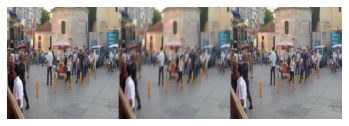

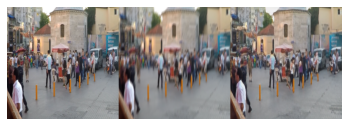

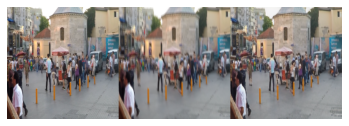

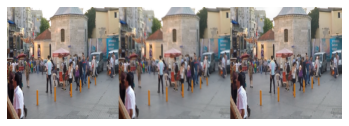

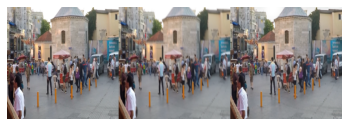

In [40]:
test(5)

In [12]:
import matplotlib.pyplot as plt
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib."""
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    rows = int(np.ceil(n_images / float(cols)))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(rows, cols, n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()


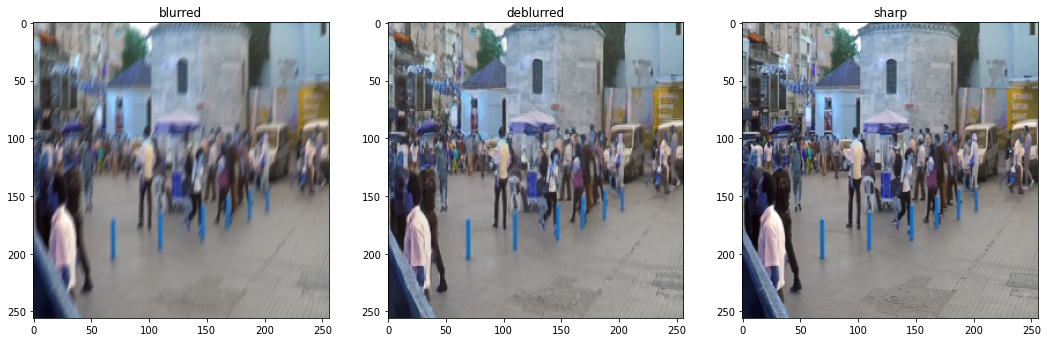

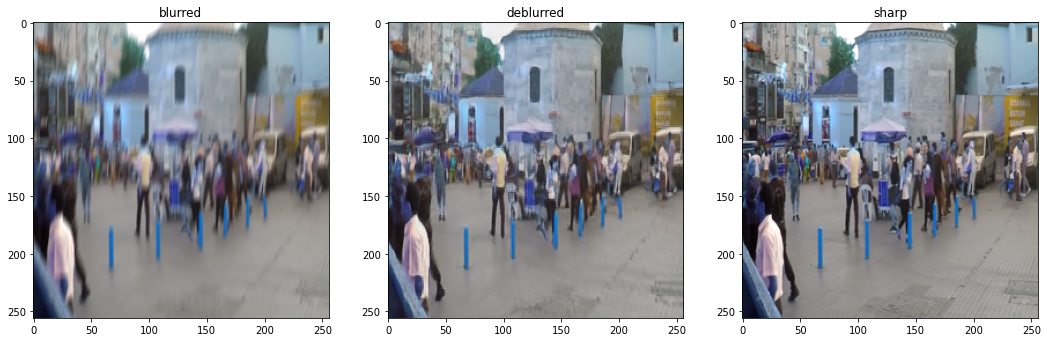

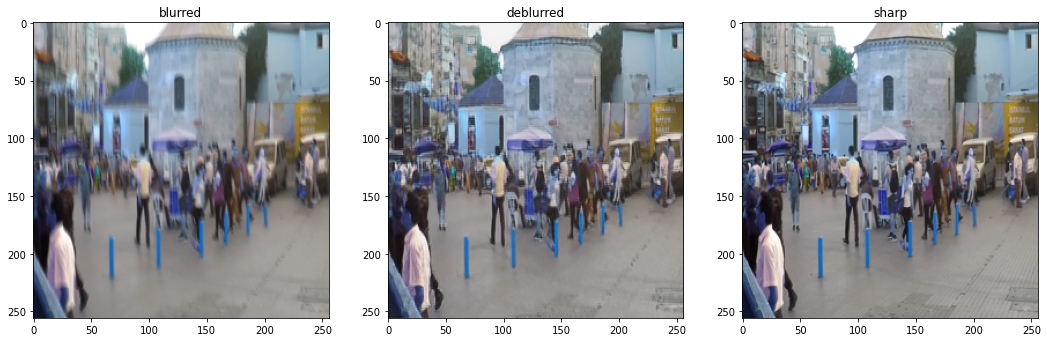

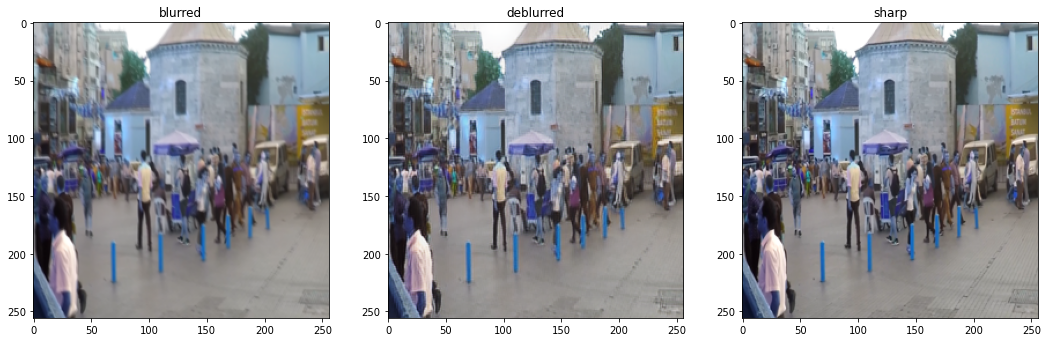

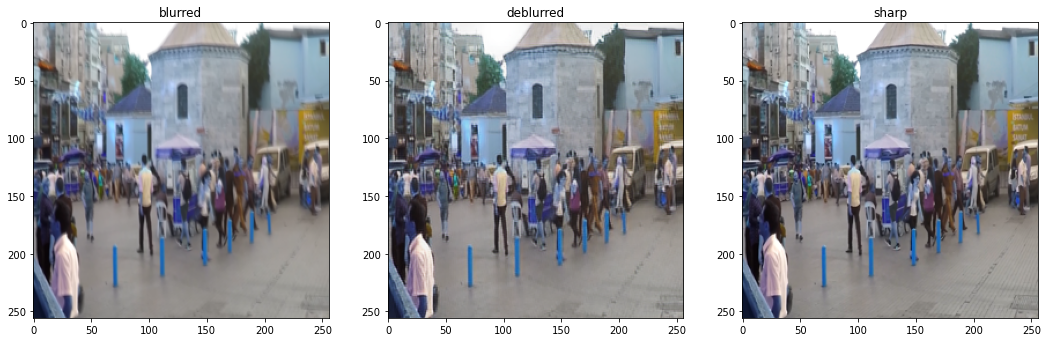

In [13]:
display_test_results(5)

In [47]:
avg_psnr1 = 0
avg_psnr2 = 0
for i in range(5):
    deblurred = Image.open(r'test_results\deblurred\image{}.png'.format(i))
    sharp = Image.open(r'test_results\sharp\image{}.png'.format(i))
    blurred = Image.open(r'test_results\blurred\image{}.png'.format(i))

    deblurred = np.array(deblurred)
    sharp = np.array(sharp)
    blurred = np.array(blurred)

    deblurred = deblurred.reshape(1,256,256,3)
    sharp = sharp.reshape(1,256,256,3)
    blurred = blurred.reshape(1,256,256,3)

    psnr1= tf.image.psnr(tf.convert_to_tensor(sharp,dtype=tf.float32), tf.convert_to_tensor(deblurred,dtype=tf.float32), max_val=255)
    psnr2= tf.image.psnr(tf.convert_to_tensor(sharp,dtype=tf.float32), tf.convert_to_tensor(blurred,dtype=tf.float32), max_val=255)
    
    avg_psnr1 += psnr1
    avg_psnr2 += psnr2

    print(i)
    print("PSNR P-T: " + str(psnr1.numpy()) + " PSNR H-T: " + str(psnr2.numpy()))
    print("\n")

avg_psnr1 = avg_psnr1.numpy()
avg_psnr2 = avg_psnr2.numpy()
print(avg_psnr1/5)
print(avg_psnr2/5)

0
PSNR P-T: [25.574856] PSNR H-T: [26.202501]


1
PSNR P-T: [25.62529] PSNR H-T: [26.26471]


2
PSNR P-T: [26.361576] PSNR H-T: [27.603178]


3
PSNR P-T: [27.705238] PSNR H-T: [28.892069]


4
PSNR P-T: [28.789492] PSNR H-T: [30.260363]


[26.81129]
[27.844564]


In [48]:
avg_ssim1 = 0
avg_ssim2 = 0
for i in range(5):
    deblurred = Image.open(r'test_results\deblurred\image{}.png'.format(i))
    sharp = Image.open(r'test_results\sharp\image{}.png'.format(i))
    blurred = Image.open(r'test_results\blurred\image{}.png'.format(i))

    deblurred = np.array(deblurred)
    sharp = np.array(sharp)
    blurred = np.array(blurred)

    deblurred = deblurred.reshape(1,256,256,3)
    sharp = sharp.reshape(1,256,256,3)
    blurred = blurred.reshape(1,256,256,3)
    
    ssim1= tf.image.ssim(tf.convert_to_tensor(sharp,dtype=tf.float32), tf.convert_to_tensor(deblurred,dtype=tf.float32), max_val=255)
    ssim2= tf.image.ssim(tf.convert_to_tensor(sharp,dtype=tf.float32), tf.convert_to_tensor(blurred,dtype=tf.float32), max_val=255)
    
    avg_ssim1 += ssim1
    avg_ssim2 += ssim2
    
    print(i)
    print("SSIM DT: " + str(ssim1.numpy()) + " SSIM DFT: " + str(ssim2.numpy()))
    print("\n")

avg_ssim1 = avg_ssim1.numpy()
avg_ssim2 = avg_ssim2.numpy()
print(avg_ssim1/5)
print(avg_ssim2/5)

0
SSIM DT: [0.8164988] SSIM DFT: [0.8308652]


1
SSIM DT: [0.81509537] SSIM DFT: [0.8298481]


2
SSIM DT: [0.85138935] SSIM DFT: [0.8700282]


3
SSIM DT: [0.8922809] SSIM DFT: [0.91033345]


4
SSIM DT: [0.9136837] SSIM DFT: [0.9298649]


[0.85778964]
[0.87418795]
